In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from sklearn.model_selection import train_test_split


In [ ]:
# Function to resize an image while maintaining the aspect ratio and scale coordinates
def resize_image_and_adjust_coordinates(input_folder, output_folder, df, target_width=600, target_height=440):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    updated_rows = []
    for index, row in df.iterrows():
        filename = row['image_path']
        img_path = os.path.join(input_folder, filename)
        img = cv2.imread(img_path)
        h, w = img.shape[:2]

        # Calculate the target dimensions while maintaining aspect ratio
        if w > h:
            new_w = target_width
            new_h = int(h * (target_width / w))
        else:
            new_h = target_height
            new_w = int(w * (target_height / h))

        resized_img = cv2.resize(img, (new_w, new_h), interpolation=cv2.INTER_AREA)

        # Adjust coordinates
        x_scale = new_w / w
        y_scale = new_h / h
        new_pixel_x = int(row['pixel_x'] * x_scale)
        new_pixel_y = int(row['pixel_y'] * y_scale)

        # Save the resized image
        output_path = os.path.join(output_folder, filename)
        cv2.imwrite(output_path, resized_img)

        # Update the row with new coordinates
        updated_row = row.copy()
        updated_row['pixel_x'] = new_pixel_x
        updated_row['pixel_y'] = new_pixel_y
        updated_rows.append(updated_row)

    return pd.DataFrame(updated_rows)


In [ ]:

input_folder = '/content/drive/MyDrive/New_IMD_IMAGEDATA/'  # Input folder containing original images
output_folder = '/content/drive/MyDrive/Resized_IMD_IMAGES/'  # Output folder for resized images

# Load data
input_file = '/content/drive/MyDrive/IMD DATAS/RESULTS.csv'
data = pd.read_csv(input_file)

# Resize images and adjust coordinates
new_data = resize_image_and_adjust_coordinates(input_folder, output_folder, data)
output_file = '/content/drive/MyDrive/IMD DATAS/Training_result.csv'
new_data.to_csv(output_file, index=False)
df = pd.read_csv(output_file)

# Load and preprocess image
def load_image_and_preprocess(base_path, relative_path):
    full_path = os.path.join(base_path, relative_path)
    img = load_img(full_path, color_mode='grayscale', target_size=(600, 440))  # Adjust target size as needed
    img_array = img_to_array(img)
    return img_array

base_path = '/content/drive/MyDrive/Resized_IMD_IMAGES/'


In [ ]:

# Prepare the dataset
def create_dataset(df, base_path):
    X = np.array([load_image_and_preprocess(base_path, path) for path in df['image_path']])
    y = df[['pixel_x', 'pixel_y']].values
    X = X / 255.0  # Normalize pixel values
    return X, y

X, y = create_dataset(df, base_path)

# Split the dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Clear session
tf.keras.backend.clear_session()

# Define the model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(600, 440, 1)),  # Adjust input shape as needed
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(2)
])

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])


In [ ]:

# Use tf.data API for efficient data loading
batch_size = 24

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val_dataset = val_dataset.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)


In [ ]:

# Train the model
try:
    history = model.fit(
        train_dataset,
        epochs=1000,
        validation_data=val_dataset
    )
except Exception as e:
    print(f"Error during model training: {e}")


Epoch 1/1000
8/8 [==============================] - 1s 124ms/step - loss: 1402.7246 - mae: 12.5813 - val_loss: 7377.4561 - val_mae: 40.0139
Epoch 2/1000
8/8 [==============================] - 1s 134ms/step - loss: 1404.8568 - mae: 11.7544 - val_loss: 7394.5127 - val_mae: 41.3479
Epoch 3/1000
8/8 [==============================] - 1s 122ms/step - loss: 1418.7028 - mae: 12.2372 - val_loss: 7392.0342 - val_mae: 41.4009
Epoch 4/1000
8/8 [==============================] - 1s 125ms/step - loss: 1425.6919 - mae: 12.9140 - val_loss: 7429.4502 - val_mae: 39.7954
Epoch 5/1000
8/8 [==============================] - 1s 121ms/step - loss: 1409.3678 - mae: 11.9627 - val_loss: 7469.6699 - val_mae: 39.0917
Epoch 6/1000
8/8 [==============================] - 1s 120ms/step - loss: 1396.6753 - mae: 11.6000 - val_loss: 7539.3950 - val_mae: 38.9417
Epoch 7/1000
8/8 [==============================] - 1s 121ms/step - loss: 1398.6941 - mae: 12.5489 - val_loss: 7450.6924 - val_mae: 38.9883
Epoch 8/1000
8/8 [==

5/5 [==============================] - 0s 70ms/step
RMSE: 50.82


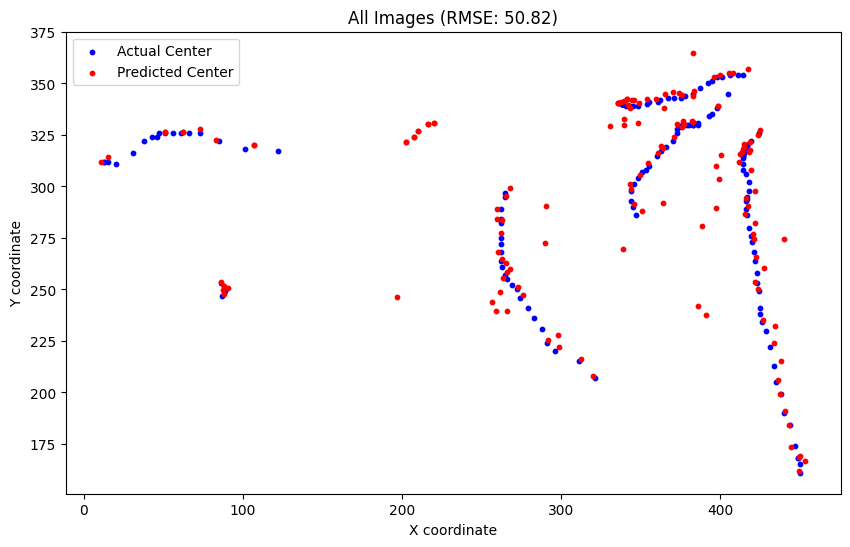

In [ ]:

# Evaluate the model and plot predictions
from sklearn.metrics import mean_squared_error
import math
import matplotlib.pyplot as plt

# Predict center coordinates on the entire dataset
y_pred = model.predict(X)

# Calculate RMSE
rmse = math.sqrt(mean_squared_error(y, y_pred))
print(f"RMSE: {rmse:.2f}")

# Extract x and y coordinates from actual and predicted center coordinates
x_actual = [coord[0] for coord in y]
y_actual = [coord[1] for coord in y]
x_pred = [coord[0] for coord in y_pred]
y_pred = [coord[1] for coord in y_pred]

# Plot actual and predicted center coordinates
plt.figure(figsize=(10, 6))
plt.scatter(x_actual, y_actual, c='blue', label='Actual Center', s=10)
plt.scatter(x_pred, y_pred, c='red', label='Predicted Center', s=10)
plt.legend()

# Add axis labels and title
plt.xlabel('X coordinate')
plt.ylabel('Y coordinate')
plt.title(f'All Images (RMSE: {rmse:.2f})')

# Show plot
plt.show()
